# Stock Price Prediction of NVIDIA Corporation (NVDA)

### 1. Tiền xử lý dữ liệu

#### 1.1 Đọc dữ liệu và xử lý các giá trị trùng, giá trị khuyết,...

In [1]:
#Khai báo thư viện
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, count, isnull
from pyspark.sql import functions as F

from pyspark.ml.feature import VectorAssembler, MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd


In [4]:
#Đọc file csv được thu thập từ trang https://finance.yahoo.com/
spark = SparkSession.builder.getOrCreate()
nvda = spark.read.csv("NVDA.csv", header=True, inferSchema=True)

In [5]:
nvda.show()

+----------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+
|      Date|               Open|               High|                Low|              Close|          Adj Close|   Volume|
+----------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+
|1999-01-22|             0.4375| 0.4882810115814209|0.38802099227905273| 0.4101560115814209|  0.376254677772522|271468800|
|1999-01-25|0.44270798563957214|0.45833298563957214| 0.4101560115814209|           0.453125| 0.4156721234321594| 51048000|
|1999-01-26|0.45833298563957214|0.46744799613952637|0.41145798563957214| 0.4179689884185791| 0.3834218978881836| 34320000|
|1999-01-27|0.41927099227905273| 0.4296880066394806|0.39583298563957214|0.41666701436042786|0.38222751021385193| 24436800|
|1999-01-28|0.41666701436042786|0.41927099227905273| 0.4127599895000458| 0.4153650104999542| 0.3810330629348755| 22752000|
|1999-01-29| 0.4

In [6]:
#Đếm số lượng dòng và cột của dataframe
print('Số dòng: ', nvda.count())
print('Số cột: ', len(nvda.columns))

Số dòng:  6279
Số cột:  7


In [7]:
#Kiểm tra số dòng trùng lặp
duplicate_rows_count = nvda.groupBy(nvda.columns).count().filter(F.col('count') > 1).count()
print("Số dòng trùng lặp là:", duplicate_rows_count)

Số dòng trùng lặp là: 0


In [8]:
#Kiểm tra giá trị null
nvda.select([count(when(isnull(c), c)).alias(c) for c in nvda.columns]).show()

+----+----+----+---+-----+---------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|
+----+----+----+---+-----+---------+------+
|   0|   0|   0|  0|    0|        0|     0|
+----+----+----+---+-----+---------+------+



In [9]:
nvda.describe().show()

+-------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+
|summary|               Open|              High|                Low|              Close|          Adj Close|             Volume|
+-------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+
|  count|               6279|              6279|               6279|               6279|               6279|               6279|
|   mean|  42.42126455665261|43.190622208063004| 41.621992766173676|  42.43908588019388|  42.17626443545631|6.094320251632425E7|
| stddev|  89.14536251176979| 90.68350524734196|  87.49831298260831|  89.14957133136069|  89.16637037612581|4.359816987143099E7|
|    min|0.34895798563957214|0.3554689884185791|0.33333298563957214|0.34114599227905273|0.31294867396354675|            1968000|
|    max|  502.1600036621094| 505.4800109863281|  494.1199951171875|  504.0899963378906|  504.045

#### 1.2 Trực quan hóa dữ liệu

In [10]:
#Chuyển dữ liệu về pandas để thực hiện vẽ biểu đồ
pandas_df = nvda.toPandas()
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])
pandas_df.set_index('Date', inplace=True)
pandas_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376255,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415672,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383422,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382228,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381033,22752000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


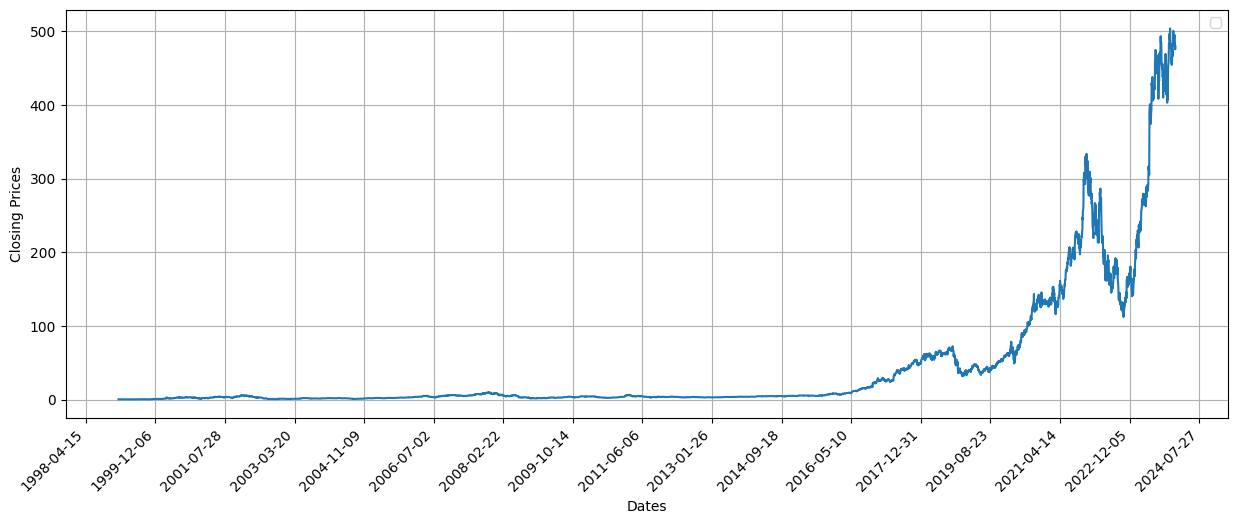

In [11]:
#Vẽ biểu đồ thể hiện sự biến đổi giá cổ phiếu qua các năm.
plt.figure(figsize=(15,6))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=600))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
x_dates = [dt.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d').date() for d in pandas_df.index.to_pydatetime()]

plt.plot(x_dates, pandas_df['Close'])
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.legend()
plt.gcf().autofmt_xdate()
plt.xticks(rotation = 45)
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


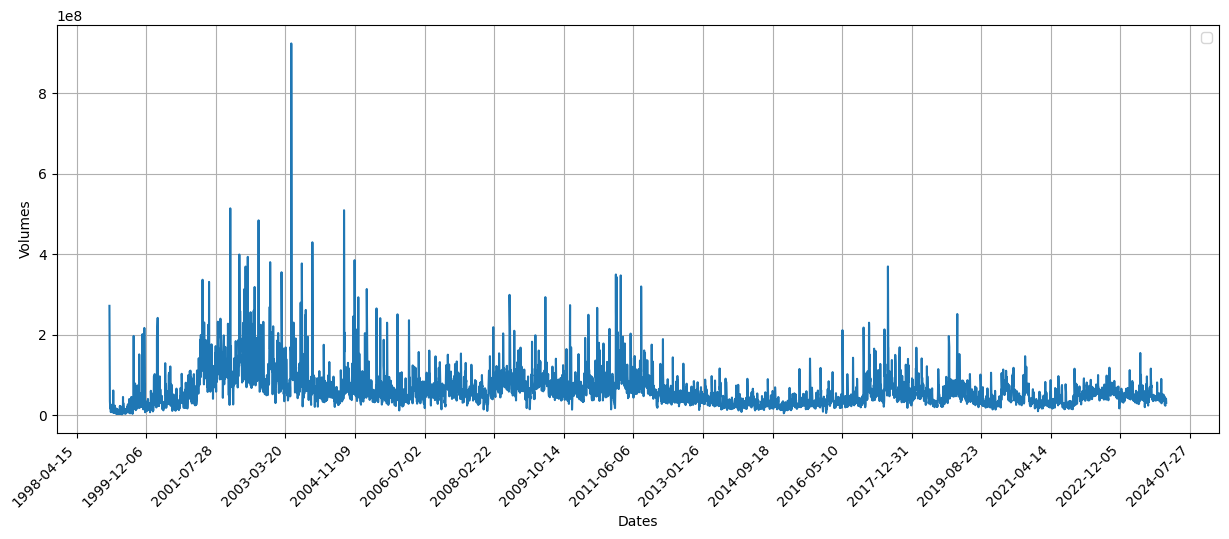

In [12]:
#Vẽ biểu đồ thể hiện sự biến đổi số lượng cổ phiếu đã giao dịch qua các năm.
plt.figure(figsize=(15,6))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=600))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
x_dates = [dt.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d').date() for d in pandas_df.index.to_pydatetime()]

plt.plot(x_dates, pandas_df['Volume'])
plt.xlabel('Dates')
plt.ylabel('Volumes')
plt.legend()
plt.gcf().autofmt_xdate()
plt.xticks(rotation = 45)
plt.grid(True)
plt.show()

#### 1.3 Chuẩn hóa dữ liệu

In [13]:
# Tạo một đối tượng VectorAssembler với các cột đầu vào Open, High, Low, Volume và cột đầu ra Features
featureAssembler = VectorAssembler(inputCols=["Open", "High", "Low", "Volume"], outputCol="Features")

# Áp dụng VectorAssembler để tạo cột "Features" trong dữ liệu đầu vào "nvda"
output = featureAssembler.transform(nvda)

In [14]:
# Tạo một đối tượng MinMaxScaler với cột đầu vào là "Features" và cột đầu ra là "ScaledFeatures", đặt phạm vi chuẩn hóa là [-1;1]
scaler = MinMaxScaler(inputCol="Features", outputCol="ScaledFeatures", min=-1, max=1)

# Fit dữ liệu vào mô hình scaler để tính toán các tham số chuẩn hóa
scalerModel = scaler.fit(output)

# Áp dụng mô hình scaler trên vào dữ liệu đầu vào "output"
scaledOutput = scalerModel.transform(output)

scaledOutput.show(truncate=False)

+----------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+-----------------------------------------------------------------------+---------------------------------------------------------------------------------+
|Date      |Open               |High               |Low                |Close              |Adj Close          |Volume   |Features                                                               |ScaledFeatures                                                                   |
+----------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+-----------------------------------------------------------------------+---------------------------------------------------------------------------------+
|1999-01-22|0.4375             |0.4882810115814209 |0.38802099227905273|0.4101560115814209 |0.376254677772522  |271468800|[0.4375,0.4882810115814209,0.38802099227905273,

In [15]:
#Tạo dữ liệu để train model gồm 3 cột "Date", "ScaledFeatures" và "Close"
print("\nGetting Column Sorted:")
finalData = scaledOutput.select("Date", "ScaledFeatures", "Close")
finalData.show(truncate=False)


Getting Column Sorted:
+----------+---------------------------------------------------------------------------------+-------------------+
|Date      |ScaledFeatures                                                                   |Close              |
+----------+---------------------------------------------------------------------------------+-------------------+
|1999-01-22|[-0.999647110141862,-0.9994741414755358,-0.9997784954076994,-0.4148395384042167] |0.4101560115814209 |
|1999-01-25|[-0.9996263533821834,-0.9995927182757182,-0.9996888412270586,-0.8934338025893762]|0.453125           |
|1999-01-26|[-0.9995640789458807,-0.9995566281247075,-0.9996835677996536,-0.9297548977459555]|0.4179689884185791 |
|1999-01-27|[-0.9997197630173935,-0.9997061357663306,-0.9997468542397229,-0.9512140469360264]|0.41666701436042786|
|1999-01-28|[-0.9997301413378433,-0.9997473810969147,-0.9996782942515393,-0.9548722117566747]|0.4153650104999542 |
|1999-01-29|[-0.9997353305574577,-0.9997576913380617,-0.

## 2. Xây dựng model

In [3]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Conv1D, MaxPooling1D
from tabulate import tabulate

In [16]:
#Chia tập dữ liệu thành 2 tập train và test với tỉ lệ 7:3
trainData, testData = finalData.randomSplit([0.7, 0.3], seed = 12)

In [17]:
print("Số giá trị của tập train: ", trainData.count())
print("Số giá trị của tập test", testData.count())

Số giá trị của tập train:  4440
Số giá trị của tập test 1839


In [18]:
trainData.show()

+----------+--------------------+-------------------+
|      Date|      ScaledFeatures|              Close|
+----------+--------------------+-------------------+
|1999-01-22|[-0.9996471101418...| 0.4101560115814209|
|1999-01-27|[-0.9997197630173...|0.41666701436042786|
|1999-01-28|[-0.9997301413378...| 0.4153650104999542|
|1999-01-29|[-0.9997353305574...|0.39583298563957214|
|1999-02-01|[-0.9998131766910...|0.40364599227905273|
|1999-02-03|[-0.9999273430859...|0.38020798563957214|
|1999-02-04|[-0.9998546902104...|0.40104201436042786|
|1999-02-05|[-0.9997664697948...| 0.4127599895000458|
|1999-02-08|[-0.9997353305574...| 0.3984380066394806|
|1999-02-09|[-0.9997716590144...| 0.3828130066394806|
|1999-02-10|[-0.9998650686496...| 0.3789060115814209|
|1999-02-11|[-0.9998754511273...|0.41145798563957214|
|1999-02-12|[-0.9997301413378...|0.43489599227905273|
|1999-02-16|[-0.9996263533821...|             0.4375|
|1999-02-17|[-0.9996886278184...| 0.4140630066394806|
|1999-02-22|[-0.999626353382

### 2.1 LinearRegression

In [19]:
LR = LinearRegression(featuresCol='ScaledFeatures', labelCol='Close')
LRModel = LR.fit(trainData)

print("Coefficients: " + str(LRModel.coefficients))
print("Intercept: " + str(LRModel.intercept))

Coefficients: [-168.78223391470814,208.8848180138047,209.04729912855865,-0.03234228430845523]
Intercept: 249.46904945129944


In [20]:
LRPredictions = LRModel.transform(testData)

In [21]:
print(LRPredictions.select("Close", "ScaledFeatures", "prediction").show(truncate=False))

+-------------------+---------------------------------------------------------------------------------+-------------------+
|Close              |ScaledFeatures                                                                   |prediction         |
+-------------------+---------------------------------------------------------------------------------+-------------------+
|0.453125           |[-0.9996263533821834,-0.9995927182757182,-0.9996888412270586,-0.8934338025893762]|0.4351188727891042 |
|0.4179689884185791 |[-0.9995640789458807,-0.9995566281247075,-0.9996835677996536,-0.9297548977459555]|0.4344238418822215 |
|0.37239599227905273|[-0.9998131766910917,-0.9997989366686458,-0.999889247643495,-0.9469305547956092] |0.3834112238215823 |
|0.42057299613952637|[-0.9996886278184862,-0.9996958254071838,-0.9996941147751729,-0.9889212843180936]|0.42607803916379794|
|0.43489599227905273|[-0.9997301413378433,-0.9996545842065961,-0.9996835677996536,-0.9879103384844671]|0.44387156482670775|
|0.45703

In [22]:
R2_Evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="r2")
R2_LR = R2_Evaluator.evaluate(LRPredictions)
print(f"R Squared (R2) on test data = ", R2_LR)

R Squared (R2) on test data =  0.9998703729355871


In [23]:
RMSE_Evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="rmse")
RMSE_LR = RMSE_Evaluator.evaluate(LRPredictions)
print(f"RMSE on test data = ", RMSE_LR)

RMSE on test data =  1.0296182631499258


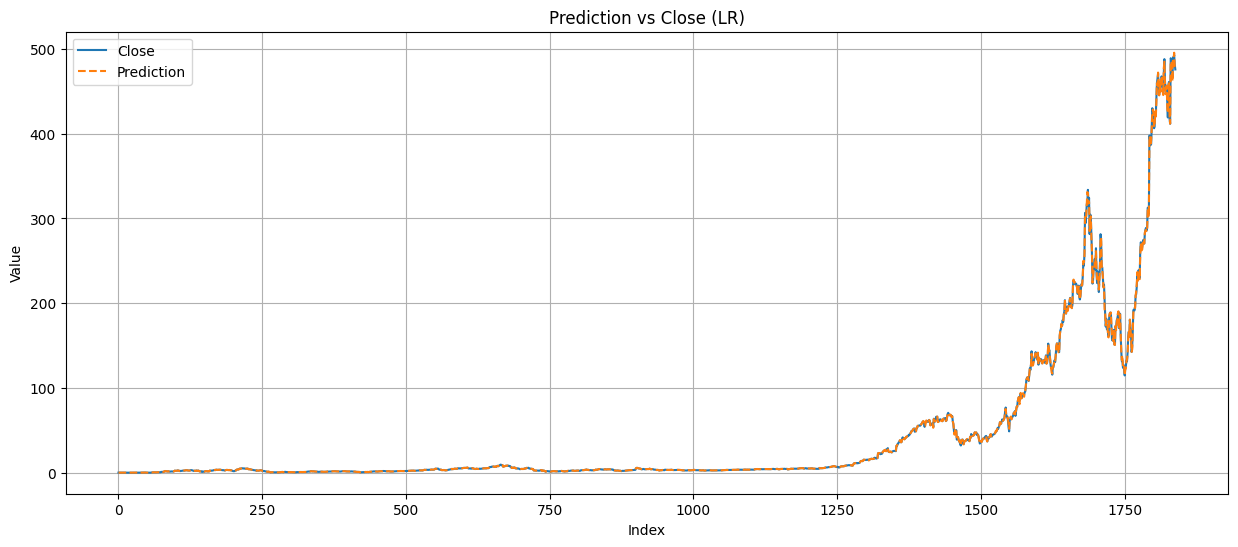

In [24]:
#Biểu đồ thể hiện Close vs Prediction (LR)

predictions = [row.prediction for row in LRPredictions.collect()]
close_values = [row.Close for row in LRPredictions.collect()]

plt.figure(figsize=(15,6))
plt.plot(close_values, label='Close', linestyle='solid')
plt.plot(predictions, label='Prediction', linestyle='dashed')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Prediction vs Close (LR)')
plt.legend()
plt.grid(True)
plt.show()

### 2.2 GBTRegressor

In [25]:
GBT = GBTRegressor(featuresCol='ScaledFeatures', labelCol='Close')
GBTModel = GBT.fit(trainData)

In [26]:
GBTPredictions = GBTModel.transform(testData)

In [27]:
print(GBTPredictions.select("Close", "ScaledFeatures", "prediction").show(truncate=False))

+-------------------+---------------------------------------------------------------------------------+------------------+
|Close              |ScaledFeatures                                                                   |prediction        |
+-------------------+---------------------------------------------------------------------------------+------------------+
|0.453125           |[-0.9996263533821834,-0.9995927182757182,-0.9996888412270586,-0.8934338025893762]|0.6372044322555664|
|0.4179689884185791 |[-0.9995640789458807,-0.9995566281247075,-0.9996835677996536,-0.9297548977459555]|0.6334478989258914|
|0.37239599227905273|[-0.9998131766910917,-0.9997989366686458,-0.999889247643495,-0.9469305547956092] |0.6212599889555906|
|0.42057299613952637|[-0.9996886278184862,-0.9996958254071838,-0.9996941147751729,-0.9889212843180936]|0.541711048161186 |
|0.43489599227905273|[-0.9997301413378433,-0.9996545842065961,-0.9996835677996536,-0.9879103384844671]|0.541711048161186 |
|0.4570310115814

In [28]:
R2_GBT = R2_Evaluator.evaluate(GBTPredictions)
print(f"R Squared (R2) on test data = ", R2_GBT)

R Squared (R2) on test data =  0.9767464426339845


In [29]:
RMSE_GBT = RMSE_Evaluator.evaluate(GBTPredictions)
print(f"RMSE on test data = ", RMSE_GBT)

RMSE on test data =  13.790280344708101


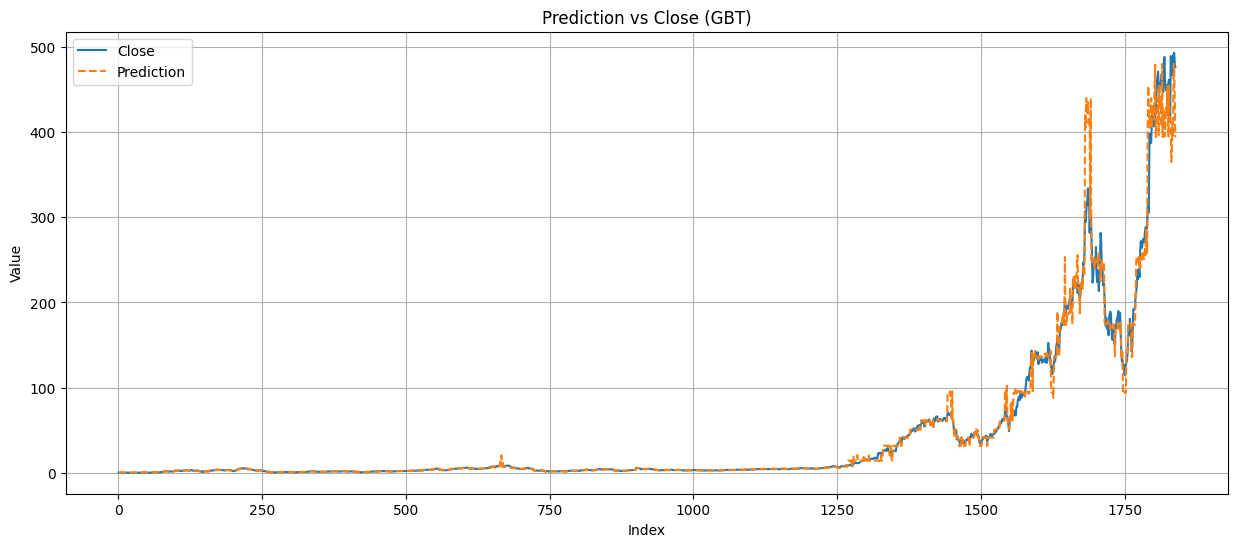

In [30]:
#Biểu đồ thể hiện Close vs Prediction (GBT)

predictions = [row.prediction for row in GBTPredictions.collect()]
close_values = [row.Close for row in GBTPredictions.collect()]


plt.figure(figsize=(15,6))
plt.plot(close_values, label='Close', linestyle='solid')
plt.plot(predictions, label='Prediction', linestyle='dashed')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Prediction vs Close (GBT)')
plt.legend()
plt.grid(True)
plt.show()

### 2.3 Xử lý dữ liệu đầu vào cho LSTM và CNN

In [31]:
#Tạo dữ liệu huấn luyện và kiểm tra với 2 cột "ScaledFeatures" và "Close"
train_data = trainData.select("ScaledFeatures", "Close").collect()
test_data = testData.select("ScaledFeatures", "Close").collect()

In [32]:
#Chuyển đổi dữ liệu từ hàng thành các mảng NumPy
train_features = np.array([item[0] for item in train_data])
train_labels = np.array([item[1] for item in train_data])

test_features = np.array([item[0] for item in test_data])
test_labels = np.array([item[1] for item in test_data])

In [33]:
#Xác định số lượng mẫu
n_samples_train = train_features.shape[0] #huấn luyện

n_samples_test = test_features.shape[0] #kiểm tra

n_features = train_features.shape[1] #đặc trưng

### 2.4 LSTM

In [34]:
#Thay đổi hình dạng của dữ liệu cho phù hợp với mô hình
train_features_0 = train_features.reshape((n_samples_train, 1, n_features)) #huấn luyện
test_features_0 = test_features.reshape((n_samples_test, 1, n_features)) #kiểm tra

In [35]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(1, n_features)))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17729 (69.25 KB)
Trainable params: 17729 (69.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
model.fit(train_features_0, train_labels, epochs=100, batch_size=32)

Epoch 1/100

139/139 [==============================] - 3s 4ms/step - loss: 9556.8213
Epoch 2/100
139/139 [==============================] - 1s 4ms/step - loss: 9264.7490
Epoch 3/100
139/139 [==============================] - 1s 4ms/step - loss: 8775.4189
Epoch 4/100
139/139 [==============================] - 1s 4ms/step - loss: 8185.4404
Epoch 5/100
139/139 [==============================] - 1s 4ms/step - loss: 7587.8037
Epoch 6/100
139/139 [==============================] - 1s 4ms/step - loss: 7015.6538
Epoch 7/100
139/139 [==============================] - 1s 4ms/step - loss: 6488.9458
Epoch 8/100
139/139 [==============================] - 1s 4ms/step - loss: 6017.1377
Epoch 9/100
139/139 [==============================] - 1s 4ms/step - loss: 5601.2915
Epoch 10/100
139/139 [==============================] - 1s 4ms/step - loss: 5235.9443
Epoch 11/100
139/139 [==============================] - 1s 4ms/step - loss: 4914.8462
Epoch 12/100
139/139 [==============================] - 1s 4ms

In [37]:
LSTMpredictions = model.predict(test_features_0)

58/58 [==============================] - 1s 3ms/step


In [38]:
headers = ["Close", "ScaledFeatures", "Predictions"]

# Convert NumPy arrays to lists
test_labels_list = test_labels.tolist()
test_features_list = test_features.tolist()
LSTMpredictions_list = LSTMpredictions.tolist()

# Combine the lists
data = list(zip(test_labels_list, test_features_list, LSTMpredictions_list))

table = tabulate(data, headers, tablefmt="pipe")
print(table)

|      Close | ScaledFeatures                                                                              | Predictions           |
|-----------:|:--------------------------------------------------------------------------------------------|:----------------------|
|   0.453125 | [-0.9996263533821834, -0.9995927182757182, -0.9996888412270586, -0.8934338025893762]        | [0.5821700096130371]  |
|   0.417969 | [-0.9995640789458807, -0.9995566281247075, -0.9996835677996536, -0.9297548977459555]        | [0.5743937492370605]  |
|   0.372396 | [-0.9998131766910917, -0.9997989366686458, -0.999889247643495, -0.9469305547956092]         | [0.5269103050231934]  |
|   0.420573 | [-0.9996886278184862, -0.9996958254071838, -0.9996941147751729, -0.9889212843180936]        | [0.6332554817199707]  |
|   0.434896 | [-0.9997301413378433, -0.9996545842065961, -0.9996835677996536, -0.9879103384844671]        | [0.631838321685791]   |
|   0.457031 | [-0.9994602868329537, -0.9994277410833782, -0.99951480

In [39]:
R2_LSTM = r2_score(test_labels, LSTMpredictions)
print("R Squared (R2) on test data =", R2_LSTM)

R Squared (R2) on test data = 0.9959345055953995


In [40]:
RMSE_LSTM = np.sqrt(mean_squared_error(test_labels, LSTMpredictions))
print("RMSE on test data =", RMSE_LSTM)

RMSE on test data = 5.766138613217004


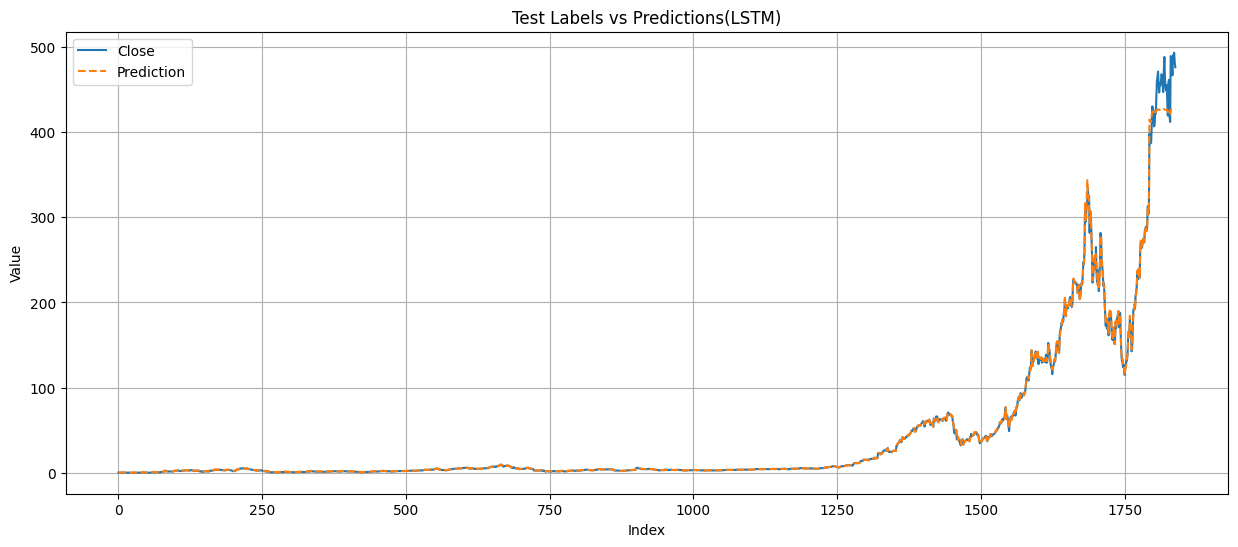

In [41]:
#Biểu đồ thể hiện Close vs Prediction (LSTM)
plt.figure(figsize=(15,6))
plt.plot(test_labels, label='Close', linestyle='solid')
plt.plot(LSTMpredictions, label='Prediction', linestyle='dashed')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Test Labels vs Predictions(LSTM)')
plt.legend()
plt.grid(True)
plt.show()

### 2.5 CNN

In [42]:
#Thay đổi hình dạng của dữ liệu cho phù hợp với mô hình
train_features_1 = train_features.reshape((n_samples_train, n_features, 1)) #huấn luyện
test_features_1 = test_features.reshape((n_samples_test, n_features, 1)) #kiểm tra

In [43]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_features, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1, activation='linear'))

cnn_model.compile(optimizer='adam', loss='mean_squared_error')
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                3250      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3493 (13.64 KB)
Trainable params: 3493 (13.64 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [44]:
cnn_model.fit(train_features_1, train_labels, epochs=100, batch_size=32, validation_data=(test_features_1, test_labels))

Epoch 1/100
139/139 [==============================] - 2s 7ms/step - loss: 9239.2725 - val_loss: 8895.2910
Epoch 2/100
139/139 [==============================] - 1s 6ms/step - loss: 6400.0381 - val_loss: 3392.7554
Epoch 3/100
139/139 [==============================] - 1s 4ms/step - loss: 1006.4462 - val_loss: 76.9700
Epoch 4/100
139/139 [==============================] - 1s 4ms/step - loss: 47.2593 - val_loss: 31.8380
Epoch 5/100
139/139 [==============================] - 1s 4ms/step - loss: 23.9441 - val_loss: 16.2448
Epoch 6/100
139/139 [==============================] - 1s 6ms/step - loss: 11.5638 - val_loss: 8.1735
Epoch 7/100
139/139 [==============================] - 1s 7ms/step - loss: 6.3400 - val_loss: 5.3509
Epoch 8/100
139/139 [==============================] - 1s 5ms/step - loss: 4.6287 - val_loss: 4.3016
Epoch 9/100
139/139 [==============================] - 1s 8ms/step - loss: 3.8124 - val_loss: 3.6880
Epoch 10/100
139/139 [==============================] - 2s 12ms/step -

In [45]:
CNNpredictions = cnn_model.predict(test_features_1)

58/58 [==============================] - 0s 2ms/step


In [46]:
headers = ["Close", "ScaledFeatures", "Predictions"]

# Convert NumPy arrays to lists
test_labels_list = test_labels.tolist()
test_features_list = test_features.tolist()
CNNpredictions_list = CNNpredictions.tolist()

# Combine the lists
data = list(zip(test_labels_list, test_features_list, CNNpredictions_list))

table = tabulate(data, headers, tablefmt="pipe")
print(table)

|      Close | ScaledFeatures                                                                              | Predictions           |
|-----------:|:--------------------------------------------------------------------------------------------|:----------------------|
|   0.453125 | [-0.9996263533821834, -0.9995927182757182, -0.9996888412270586, -0.8934338025893762]        | [0.5015093088150024]  |
|   0.417969 | [-0.9995640789458807, -0.9995566281247075, -0.9996835677996536, -0.9297548977459555]        | [0.5047239065170288]  |
|   0.372396 | [-0.9998131766910917, -0.9997989366686458, -0.999889247643495, -0.9469305547956092]         | [0.4886792302131653]  |
|   0.420573 | [-0.9996886278184862, -0.9996958254071838, -0.9996941147751729, -0.9889212843180936]        | [0.49538958072662354] |
|   0.434896 | [-0.9997301413378433, -0.9996545842065961, -0.9996835677996536, -0.9879103384844671]        | [0.49753502011299133] |
|   0.457031 | [-0.9994602868329537, -0.9994277410833782, -0.99951480

In [47]:
R2_CNN = r2_score(test_labels, CNNpredictions)
print("R Squared (R2) on test data =", R2_CNN)

R Squared (R2) on test data = 0.9995982917996269


In [48]:
RMSE_CNN = np.sqrt(mean_squared_error(test_labels, CNNpredictions))
print("RMSE on test data =", RMSE_CNN)

RMSE on test data = 1.8125239050956836


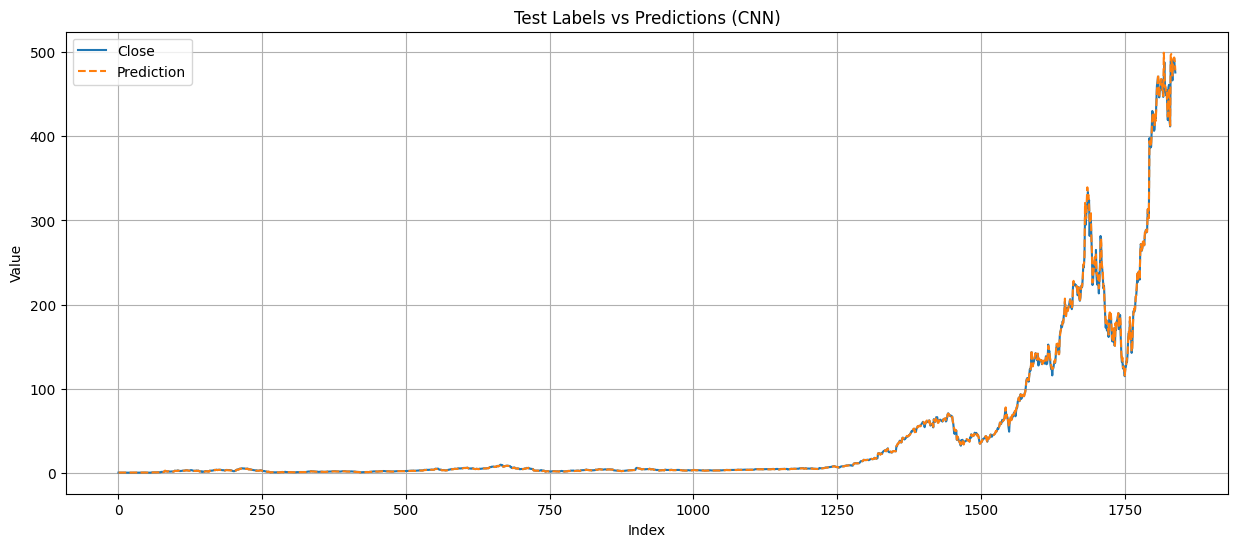

In [49]:
#Biểu đồ thể hiện Close vs Prediction (CNN)
plt.figure(figsize=(15,6))
plt.plot(test_labels, label='Close', linestyle='solid')
plt.plot(CNNpredictions, label='Prediction', linestyle='dashed')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Test Labels vs Predictions (CNN)')
plt.legend()
plt.grid(True)
plt.show()

=> LinearRegression là model tốt nhất